# Chapter 8: Recommender Systems.

In this notebook we will see how to create a recommender system. To
this end we will explore different properties of recommender systems, develope and evaluate a collaborative recommender system.



In [1]:
import matplotlib.pylab as plt

%matplotlib inline 
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex=True)
plt.rc('font', family='times')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rc('font', size=12) 

## Data description

We will work with the well known MovieLens dataset (http://grouplens.org/datasets/movielens/). This dataset was initially constructed to support participants in the Netflix Prize. Today, we can find several versions of this dataset with different amout of data, from 100k samples version to 20m sample version.
Although performance on bigger dataset is expected to be better, we will work with the smallest dataset: MovieLens *100K Dataset (ml-100k-zip)*. Working with this lite version has the benefit of less computational costs, while we will also get the skills required on user-based recommender systems.

With a unix machine the dataset can be downloaded with the following code:

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip 
!unzip ml-100k.zip -d "files/ch09/"

zsh:1: command not found: wget
unzip:  cannot find or open ml-100k.zip, ml-100k.zip.zip or ml-100k.zip.ZIP.


If you are working with a windows machine, please go to the website and download the 100k version and extract it to the subdirectory named "files/ch8/ml-100k/"

Once you have downloaded and unzipped the file into a directory, you can create a DataFrame with the following code:

In [3]:
#NETFLIX REAL 50.000.000 usuaris and 100.000 items
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
from math import isnan
from tqdm import tqdm # conda install -y tqdm


# Load Data set
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('files/ch09/ml-100k/u.user', sep='|', names=u_cols)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('files/ch09/ml-100k/u.data', sep='\t', names=r_cols)

# the movies file contains columns indicating the movie's genres
# let's only load the first three columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date']
movies = pd.read_csv('files/ch09/ml-100k/u.item', sep='|', names=m_cols, usecols=range(3), encoding='latin-1')

# Construcció del DataFrame
data = pd.merge(pd.merge(ratings, users), movies)
data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]



n_users = data.user_id.nunique()
n_items = data.movie_id.nunique()


print("The database has "+ str(data.shape[0]) +" observed ratings")
print("The database has ", data.user_id.nunique()," users")
print("The database has ", data.movie_id.nunique(), " movies")
print(data.head())

The database has 100000 observed ratings
The database has  943  users
The database has  1682  movies
   user_id         title  movie_id  rating release_date sex  age
0      196  Kolya (1996)       242       3  24-Jan-1997   M   49
1      305  Kolya (1996)       242       5  24-Jan-1997   M   23
2        6  Kolya (1996)       242       4  24-Jan-1997   M   42
3      234  Kolya (1996)       242       4  24-Jan-1997   M   60
4       63  Kolya (1996)       242       3  24-Jan-1997   M   31


If you explore the dataset in detail, you will see that it  consists of:
<ul>
<li>1,000,209 ratings from 6040 users of 3706 movies. Ratings are from 1 to 5.</li>
<li>Each user has rated at least 20 movies.</li>
<li>Simple demographic info for the users (age, gender, occupation, zip)</li>
</ul>

## Building a Collaborative Filtering (CF) for Movilens dataset
The idea behind any recommender system is to suggest or recommend items that are likely to be of interest to the user. If we think on the movielens dataset and a movie recommender system, the goal will consist on recommend those useen movies by a given "user" that are more likely to be intersting to him or her. So, the problem can be taken by predicting the ratings for the unseen movies of the given "user" and recommend those with the highest predicted rating.

<br>The following table ilustrates the problem. This toy dataset consists on 4 users and 4 items.  Users 1, 2 and 3 have seen all the movies while user 3 has only seen Superman and Star Wars. So, the problem consist on prediction which movie, Matrix or Spiderman, will be more likely for the user 4.
<table style="width:60%">
  <tr>
    <td></td>
    <td>Superman</td> 
    <td>Star Wars 1</td>
    <td>Matrix</td>
    <td>Spiderman</td>
    
  </tr>
  <tr>
    <td>user1</td>
    <td>3</td> 
    <td>3.5</td>
    <td>4.5</td>
    <td>3</td>
  </tr>
  <tr>
    <td>user2</td>
    <td>3.5</td> 
    <td>4</td>
    <td>5</td>
    <td>5</td>
  </tr>
  <tr>
    <td>user3</td>
    <td>3</td> 
    <td>4</td>
    <td>4.5</td>
    <td>3</td>
  </tr>
  <tr>
    <td>user4</td>
    <td>3.5</td> 
    <td>5</td>
    <td><font color="red"><b>¿?</b></font></td>
    <td><font color="red"><b>¿?</b></font></td>
  </tr>
</table>
<br><br><br><br>


In order to create a collaborative recommender system we will have to define: 1) a prediction function, 2) a user-similarity function and 3) an evaluation function.

### Prediction function:
The prediction function behind the CF will be based on the movie ratings from similar users.
So, in order to recommend a movie, $p$, from a set of movies, $P$, to a given user, $a$, we first need to see the set of users, $B$, who have already seen $p$. Then, we need to see the taste similarity between these users in $B$ and user $a$. The most simple prediction function for a user $a$ and movie $p$ can be defined as follows:

$$pred(a,p) = \frac{\sum_{b \in B}{sim(a,b)*(r_{b,p})}}{\sum_{b \in B}{sim(a,b)}}$$

where $sim(a,b)$ is the similarity between user $a$ and user $b$,  $B$ is the set of users in the dataset that have already seen $p$ and $r_{b,p}$ is the rating of $p$ by $b$.

<h3>Users similarity</h3>
The computation of the similarity between items is one of the most critical steps in the CF algorithms. The basic idea behind the similarity computation between two users $a$ and $b$, is that we can first isolate the set $P$ of items rated by both users, and then apply a similarity computation technique to determine the similarity.

The set of *common_movies* can be obtained with the following code:

In [4]:
# dataframe with the data from user 1
data_user_1 = data[data.user_id==1]
# dataframe with the data from user 2
data_user_2 = data[data.user_id==6]
# We first compute the set of common movies
common_movies = set(data_user_1.movie_id).intersection(data_user_2.movie_id)
print("\nNumber of common movies",len(common_movies),'\n')

# create a subdataframe that only contains the common movies between users
mask = (data_user_1.movie_id.isin(common_movies))
data_user_1 = data_user_1[mask]
print(data_user_1[['title','rating']].head())

mask = (data_user_2.movie_id.isin(common_movies))
data_user_2 = data_user_2[mask]
print(data_user_2[['title','rating']].head())


Number of common movies 96 

                                    title  rating
14                           Kolya (1996)       5
940                Raising Arizona (1987)       4
1306  Truth About Cats & Dogs, The (1996)       5
2677                          Babe (1995)       1
3073   Four Weddings and a Funeral (1994)       3
                                    title  rating
2                            Kolya (1996)       4
885                Raising Arizona (1987)       5
1255  Truth About Cats & Dogs, The (1996)       2
2636                          Babe (1995)       4
3022   Four Weddings and a Funeral (1994)       3


Once the set of ratings for all movies common to the two users has been obtained, we can compute the user similarity. These are some of the most common similarity functions used in CF methods: 

   <ul>
    <li>Euclidean distance</li>
    $$sim(a,b) = \sqrt{\sum_{p \in P}{(r_{a,p} - r_{b,p})^2}}$$
    <br>
    <li>Pearson Correlation</li>
    $$sim(a,b) = \frac{\sum_{p\in P} (r_{a,p}-\bar{r_a})(r_{b,p}-\bar{r_b})}{\sqrt{\sum_{p \in P}(r_{a,p}-\bar{r_a})²}\sqrt{\sum_{p \in P}(r_{b,p}-\bar{r_b})²}}$$
    <br>
    <li>Cosine distance</li>
    $$ sim(a,b) = \frac{\vec{a}· \vec{b}}{|\vec{a}| * |\vec{b}|}$$
    <br>
    </ul>
  
<br>
Where: 

* $sim(a,b)$ is the similarity between user "a" and user "b"
* $P$ is the set of common rated movies by user "a" and "b"
* $r_{a,p}$ is the rating of movie "p" by user "a"
* $\bar{r_a}$ is the mean rating given by user "a"

<br>

<h4>Some issues to take into accout</h4>
<ul>
<li>Pearson Correlation used to work better than euclidean distance since it is based more on the ranking than on the values.</li>
<li>Cosine distance is usually used when our data is binary/unary, i.e. like vs. not like  or buy vs. not buy.</li>
<li>What happens if two users have very few items in common?</li>
</ul>



Let's define a function to compute the users similarity 

In [5]:
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean

# Returns a user-based similarity score for user_1 and user_2
def user_similarity(dataFrame, user_1, user_2, min_common_items = 1, method = 'pearson'):
    # GET MOVIES OF USER1
    movies_user1 = dataFrame[dataFrame['user_id'] == user_1 ]
    # GET MOVIES OF USER2
    movies_user2 = dataFrame[dataFrame['user_id'] == user_2 ]
    
    # FIND SHARED FILMS
    df_shared = pd.merge(movies_user1, movies_user2, on = 'movie_id')  
    
    if(df_shared.shape[0]<=min_common_items):
        return 0
    
    if method =='pearson':
        res=pearsonr(df_shared['rating_x'],df_shared['rating_y'])[0]
        if(np.isnan(res)):
            return 0
        return res
    
    elif method =='euclidean':
        return 1.0/(1.0+euclidean(df_shared['rating_x'],df_shared['rating_y'])) 
    else:
        print("method not defined")
        return 0

Let's see how similars are user 1 with 8 and 1 with 31

In [6]:
user_id_1, user_id_2 = 1, 8
print("Euclidean Similarity",user_similarity(data,user_id_1,user_id_2,method = 'euclidean') )
print("Pearson Similarity",user_similarity(data,user_id_1,user_id_2) )

Euclidean Similarity 0.1566130288262323
Pearson Similarity 0.6920863660773593


In [7]:
user_id_1, user_id_2 = 1, 31
print("Euclidean Similarity",user_similarity(data,user_id_1,user_id_2,method = 'euclidean') )
print("Pearson Similarity",user_similarity(data,user_id_1,user_id_2) )

Euclidean Similarity 0.1757340838011157
Pearson Similarity -0.09221388919541466


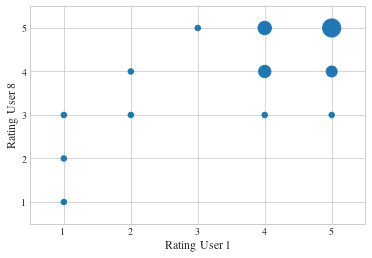

In [8]:
user_id_1, user_id_2 = 1, 8
movies_user1=data[data['user_id'] ==user_id_1 ][['user_id','movie_id','rating']]
movies_user2=data[data['user_id'] ==user_id_2 ][['user_id','movie_id','rating']]
    
# FIND SHARED FILMS
rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')
x= rep.rating_x + np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_x))
y= rep.rating_y +np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_y))
    
a=rep.groupby(['rating_x', 'rating_y']).size()
x=[]
y=[]
s=[]
for item,b in a.iteritems():
    x.append(item[0])
    y.append(item[1])
    s.append(b*30)

fig = plt.figure(figsize=(6,4))
plt.scatter(x,y, s=s)
plt.xlabel('Rating User 1')
plt.ylabel('Rating User '+str(8))
plt.axis([0.5,5.5,0.5,5.5])
plt.savefig("corre18.png",dpi= 300, bbox_inches='tight')
plt.show()

And, with user 31:

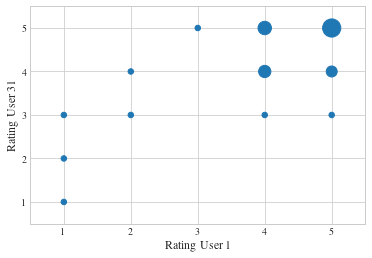

In [9]:
user_id_1, user_id_2 = 1, 8
movies_user1=data[data['user_id'] ==user_id_1 ][['user_id','movie_id','rating']]
movies_user2=data[data['user_id'] ==user_id_2 ][['user_id','movie_id','rating']]
    
# FIND SHARED FILMS
rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')
x= rep.rating_x + np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_x))
y= rep.rating_y +np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_y))
    
a=rep.groupby(['rating_x', 'rating_y']).size()
x=[]
y=[]
s=[]

fig = plt.figure(figsize=(6,4))
for item,b in a.iteritems():
    x.append(item[0])
    y.append(item[1])
    s.append(b*30)
plt.scatter(x,y, s=s)
plt.xlabel('Rating User 1')
plt.ylabel('Rating User '+str(31))
plt.axis([0.5,5.5,0.5,5.5])
plt.savefig("corre131.png",dpi= 300, bbox_inches='tight')
plt.show()


<h3>Evaluation: performance criterion</h3>
In order to validate the system, we will divide the dataset into two different sets: one called \emph{$X\_train$} containing  $80\%$ of the data from each user; and another called \emph{$X\_test$}, with the remaining $20\%$ of the data from each user. In the following code we create a function

In [10]:
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.2)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return df

def create_train_test(data,key = 'user_id'):
    data['for_testing'] = False
    grouped = data.groupby(key, group_keys=False).apply(assign_to_set)
    # dataframe used to train our model
    data_train = data[grouped.for_testing == False]
    # dataframe used to evaluate our model
    data_test = data[grouped.for_testing == True]
    return data_train, data_test


data_train, data_test =  create_train_test(data)

print("Training data_set has "+ str(data_train.shape[0]) +" ratings")
print("Test data set has "+ str(data_test.shape[0]) +" ratings")

Training data_set has 79619 ratings
Test data set has 20381 ratings



Once the data is divided in these sets, we can build a model with the **training set** and evaluate its performance using the **test set**. In our case, the evaluation will be performed using the standard RMSE:

In [11]:
def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

Instead, we can use ranking measures such us Average Precision.

In [12]:
def precision(recommended_items, relevant_items):
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

def recall(recommended_items, relevant_items):  
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

We define the function **evaluate** which computes the Root Mean Square Error (RMSE).

In [13]:
def evaluate(recommender_object, train, test, at = 5, thr_relevant= 4, ranking = True):
    """ Perfomance evaluation """
    
    # RMSE evaluation
    ids_to_estimate = zip(test.user_id, test.movie_id)
    estimated = np.array([recommender_object.predict_score(u,i) if u in train.user_id else 3 for (u,i) in ids_to_estimate ])
    real = test.rating.values
    rmse = compute_rmse(estimated, real)
    
    if(ranking):
    # Ranking metrics
        cumulative_precision = 0.0
        cumulative_recall = 0.0
        cumulative_AP = 0.0

        num_eval = 0

        for user_id in tqdm(test.user_id.unique()):

            relevant_items = test[(test.user_id==user_id )&( test.rating>=thr_relevant)].movie_id.values

            if len(relevant_items)>0:

                recommended_items = recommender_object.predict_top(user_id, at=at)
                num_eval+=1

                cumulative_precision += precision(recommended_items, relevant_items)
                cumulative_recall += recall(recommended_items, relevant_items)
                cumulative_AP += AP(recommended_items, relevant_items)

        cumulative_precision /= num_eval
        cumulative_recall /= num_eval
        MAP = cumulative_AP / num_eval

        print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
            cumulative_precision, cumulative_recall, MAP)) 
    
    
    return rmse

## Recommender System 
We can define our recommender system with a Python class. This class consists of a constructor and two methods: fit and predict.

First of all, let's build our naive recommender: A random recommender system.

In [14]:
data_train, data_test =  create_train_test(data)

print("#Training samples = ",data.shape[0])
print("#Test samples = ",data.shape[0])
print('#Users =', data.user_id.nunique())
print('#Movies =',data.movie_id.nunique())

#Training samples =  100000
#Test samples =  100000
#Users = 943
#Movies = 1682


In [15]:
class RandomRecommender():

    def fit(self, train):
        self.items = train.title.unique()
    
    def predict_score(self, user_id, movie_id):
        '''Given a user_id and item_id predict it score'''
        return np.random.uniform(1,5)
    
    def predict_top(self, user_id, at=5):
        recommended_items = np.random.choice(self.items, at)

        return recommended_items

In [16]:
reco_random = RandomRecommender()
reco_random.fit(data_train)
reco_random.predict_score(user_id=2,movie_id=1)

2.7739277641418965

In [17]:
print('RMSE for Collaborative Recomender: %s' % evaluate(reco_random,data_train,data_test))

100%|███████████████████████████████████████| 943/943 [00:00<00:00, 1528.48it/s]

Recommender results are: Precision = 0.0000, Recall = 0.0000, MAP = 0.0000
RMSE for Collaborative Recomender: 1.6171498952759904


In [18]:
class CollaborativeFiltering:
    """ Collaborative filtering using a custom sim(u,u'). """
    
    def __init__(self, similarity = 'pearson'):
        """ Constructor """
        self.sim_method=similarity# Gets recommendations for a user by using a weighted average
        self.sim = {}

    def fit(self, train):
        """ Prepare data structures for estimation. Similarity matrix for users """
        print("Learning...")
        self.train = train
        allUsers=set(self.train['user_id'])
        
        for user_1 in tqdm(allUsers):
            self.sim.setdefault(user_1, {})
            a = self.train[self.train['user_id']==user_1][['movie_id']]
            data_reduced = pd.merge(self.train,a,on='movie_id') # reduce time complexity
            for user_2 in allUsers:
                if user_1 == user_2: continue
                self.sim.setdefault(user_2, {})
                if(user_1 in self.sim[user_2]):continue # since is a simetric matrix
                sim = user_similarity(data_reduced, user_1, user_2, method = self.sim_method)
                
                if(sim < 0):
                    self.sim[user_1][user_2]=0
                    self.sim[user_2][user_1]=0
                else:
                    self.sim[user_1][user_2]=sim
                    self.sim[user_2][user_1]=sim
                
    def predict_score(self, user_id, movie_id):
        totals={}
        movie_users=self.train[self.train['movie_id'] ==movie_id]
        rating_num=0.0
        rating_den=0.0
        allUsers=set(movie_users['user_id'])
        for other in allUsers:
            if user_id==other: continue 
            rating_num += self.sim[user_id][other] * float(movie_users[movie_users['user_id']==other]['rating'])
            rating_den += self.sim[user_id][other]
        if rating_den==0: 
            if self.train.rating[self.train['movie_id']==movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.train.rating[self.train['movie_id']==movie_id].mean()
            else:
                # else return mean user rating 
                return self.train.rating[self.train['user_id']==user_id].mean()
        return rating_num/rating_den

    def predict_top(self, user_id, at=5, remove_seen=True):
        '''Given a user_id predict its top AT items'''
        seen_items = self.train[self.train.user_id==user_id].movie_id.values
        unseen_items = set(self.train.movie_id.values) - set(seen_items)

        predictions = [(item_id,self.predict_score(user_id,item_id)) for item_id in unseen_items]

        sorted_predictions = sorted(predictions, key=lambda x: x[1],reverse = True)[:at]
        return [i[0] for i in sorted_predictions]

In [19]:
reco = CollaborativeFiltering()
reco.fit(data_train)
reco.predict_score(user_id = 2, movie_id = 1)

Learning...


  0%|                                                   | 0/943 [00:00<?, ?it/s]/Users/santisegui/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|█████████████████████████████████████████| 943/943 [16:54<00:00,  1.08s/it]


3.845462644171009

In [20]:
reco.predict_top(user_id = 2)

[1026, 1189, 1558, 1122, 1191]

In [ ]:
print('RMSE for Collaborative Recomender: %s' % evaluate(reco,data_train,data_test))

  1%|▍                                        | 9/943 [02:13<4:22:06, 16.84s/it]

<div class  = "alert alert-success">**EXERCISE 1**<p>
Modify the Recomender System using as a prediction function the following equation:
$$pred(a,p) = \bar{r_a} + \frac{\sum_{b \in N}{sim(a,b)*(r_{b,p}-\bar{r_b})}}{\sum_{b \in N}{sim(a,b)}}$$

</div>

In [ ]:
class CollaborativeFiltering_Ex1(CollaborativeFiltering):
    def predict_score(self, user_id, movie_id, N = 10):
        totals={}
        movie_users=self.train[self.train['movie_id'] ==movie_id]
        rating_num=0.0
        rating_den=0.0
        allUsers=set(movie_users['user_id'])
        top_users = sorted([(self.sim[user_id][other],other) for other in movie_users.user_id.values if other in self.sim[user_id]])[::-1]
        for other in allUsers:
            if user_id==other: continue 
            rating_num += self.sim[user_id][other] * float(movie_users[movie_users['user_id']==other]['rating'] - self.train[self.train['user_id']==other].rating.mean())  
            rating_den += self.sim[user_id][other]
        if rating_den==0: 
            if self.train.rating[self.train['movie_id']==movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.train.rating[self.train['movie_id']==movie_id].mean()
            else:
                # else return mean user rating 
                return self.train.rating[self.train['user_id']==user_id].mean()
        mean_rating_user = self.train[self.train.user_id==user_id].rating.mean()
        return mean_rating_user + rating_num/rating_den

In [ ]:
reco2 = CollaborativeFiltering_Ex1()
reco2.fit(data_train)
reco.predict_score(user_id = 2, movie_id = 1)

In [ ]:
print('RMSE for Collaborative Recomender: %s' % evaluate(reco2,data_train,data_test))

<div class="alert alert-success">
**EXERCISE 2:**<br>
Modify the recomender system from the previous exercice, with one that in order to estimate the score of a movie B for the user A only uses the subset of the N most similar users to user A. Define N as a parameter of the Recoomender.
</div>

In [ ]:
class CollaborativeFiltering_Ex2(CollaborativeFiltering):
    def predict_score(self, user_id, movie_id, N = 10):
        totals={}
        movie_users=self.train[self.train['movie_id'] ==movie_id]
        rating_num=0.0
        rating_den=0.0
        allUsers=set(movie_users['user_id'])
        # SELECT TOP USERS
        top_users = sorted([(self.sim[user_id][other],other) for other in movie_users.user_id.values if other in self.sim[user_id]])[::-1]
        for sim, other in top_users[:N]:
            if user_id==other: continue 
            rating_num += self.sim[user_id][other] * float(movie_users[movie_users['user_id']==other]['rating'] - self.train[self.train['user_id']==other].rating.mean())  
            rating_den += self.sim[user_id][other]
        if rating_den==0: 
            if self.train.rating[self.train['movie_id']==movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.train.rating[self.train['movie_id']==movie_id].mean()
            else:
                # else return mean user rating 
                return self.train.rating[self.train['user_id']==user_id].mean()
        mean_rating_user = self.train[self.train.user_id==user_id].rating.mean()
        return mean_rating_user + rating_num/rating_den

In [ ]:
reco3 = CollaborativeFiltering_Ex2()
reco3.fit(data_train)
reco.predict_score(user_id = 2, movie_id = 1)

In [ ]:
print('RMSE for Collaborative Recomender V1: %s' % evaluate(reco,data_train,data_test))
print('RMSE for Collaborative Recomender V2: %s' % evaluate(reco2,data_train,data_test))
print('RMSE for Collaborative Recomender V3: %s' % evaluate(reco3,data_train,data_test))

<div class  = "alert alert-success">**EXERCISE 4**<p>
Modify the similarity function with the following:
$$new\_sim(a,b) = sim(a,b) * \frac{min(50,|P_{ab}|)}{50} $$
where $|P_{ab}|$ is the number of common items with user $a$ and user $b$
</div>

In [ ]:
# Returns a pearsonCorrealation-based similarity score for person1 and person2
def SimPearsonCorrected(DataFrame,User1,User2,min_common_items=1,pref_common_items=20):
    # GET MOVIES OF USER1
    movies_user1=DataFrame[DataFrame['user_id'] ==User1 ]
    # GET MOVIES OF USER2
    movies_user2=DataFrame[DataFrame['user_id'] ==User2 ]
    
    # FIND SHARED FILMS
    rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')
    if len(rep)==0:
        return 0    
    if(len(rep)<min_common_items):
        return 0    
    res=pearsonr(rep['rating_x'],rep['rating_y'])[0] * min(pref_common_items,len(rep))/pref_common_items
    if(isnan(res)):
        return 0
    return res

reco4 = CollaborativeFiltering3(data_train,similarity=SimPearsonCorrected,min_common_items=1,max_sim_users=10)
reco4.learn()
reco4.estimate(user_id=2,movie_id=1)

In [ ]:
print('RMSE for Collaborative Recomender: %s' % evaluate(reco4,data_train,data_test))

<div class="alert alert-success">
**EXERCISE 5:**
Create an item-based recommender system. <br>Instead of computing similiarity between users we need to compute similarities between items. 
</div>

In [ ]:
class CollaborativeFilteringItemBased:
    """ Item-Based Collaborative filtering using a custom sim(p,p'). """
    
    def __init__(self,DataFrame, similarity=SimPearson,min_common_items=10,max_sim_movies=10):
        """ Constructor """
        self.sim_method=similarity# Gets recommendations for a person by using a weighted average
        self.df=DataFrame
        self.sim = pd.DataFrame(np.sum([0]),columns=data_train.movie_id.unique(), index=data_train.movie_id.unique())
        self.min_common_items=min_common_items
        self.max_sim_movies=max_sim_movies

    def learn(self):
        """ Prepare data structures for estimation. Similarity matrix for users """
        allMovies=set(self.df['movie_id'])
        self.sim = {}
        for movie1 in allMovies:
            self.sim.setdefault(movie1, {})
            a=data_train[data_train['movie_id']==movie1][['user_id']]
            data_reduced=pd.merge(data_train,a,on='user_id')
            for movie2 in allMovies:
                # no es comparem am nosalres mateixos
                if movie1==movie2: continue
                self.sim.setdefault(movie2, {})
                if(self.sim[movie2].has_key(movie1)):continue # since is a simetric matrix
                sim=self.sim_method(data_reduced,movie1,movie2,self.min_common_items)
                #print movie1,movie2,sim
                if(sim<0):
                    self.sim[movie1][movie2]=0
                    self.sim[movie2][movie1]=0
                else:
                    self.sim[movie1][movie2]=sim
                    self.sim[movie2][movie1]=sim
                
                
                
    def estimate(self, user_id, movie_id):
        
        totals={}
        movie_users=self.df[self.df['user_id'] ==user_id]
        rating_num=0.0
        rating_den=0.0
        allMovies=set(movie_users['movie_id'])
        
        listOrdered=sorted([(self.sim[movie_id][other],other) for other in allMovies if movie_id!=other],reverse=True)
        
        for item in range(min(len(listOrdered),self.max_sim_movies)):
            other=listOrdered[item][1]
            rating_num += self.sim[movie_id][other] * (float(movie_users[movie_users['movie_id']==other]['rating']))
            rating_den += self.sim[movie_id][other]
        if rating_den==0: 
            if self.df.rating[self.df['movie_id']==movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.df.rating[self.df['movie_id']==movie_id].mean()
            else:
                # else return mean user rating 
                return self.df.rating[self.df['user_id']==user_id].mean()
        return rating_num/rating_den

In [ ]:
reco5 = CollaborativeFilteringItemBased(dataSmall_train,similarity=SimPearson,min_common_items=1,max_sim_movies=10)
reco5.learn()
reco5.estimate(user_id=2,movie_id=1)